# Visualization of Torsiondrive results as energy countour and interactive molecular structures.

Execute this cell, no user input needed here

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import nglview as nv
from IPython.display import display

# Filter out a harmless numpy warning
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

def energy_plot_from_xyz(filename):
    # Parse dihedrals and energies. From Yudong's script.
    with open(filename) as f:
        lines = f.readlines()
    global n_atoms 
    n_atoms = int(lines[0])
    comment_lines = lines[1::n_atoms+2]
    grid_data = dict()
    for line in comment_lines:
        ls = line.strip().split()
        assert ls[0] == 'Dihedral' and ls[-2] == 'Energy', line
        grid_energy = float(ls[-1])
        grid_coord = []
        for i in range(1, len(ls) - 2):
            c = int(ls[i].replace('(', '').replace(',','').replace(')',''))
            grid_coord.append(c)
        grid_data[tuple(grid_coord)] = grid_energy
        
    # auto determination of No. of scan points (xpts, ypts), minimum values (xmin, ymin) and step size (xstep,ystep)
    i = 0
    while lines[1+i*(n_atoms+2)].strip().split()[1] == lines[1+(i+1)*(n_atoms+2)].strip().split()[1] != 0:
        i=i+1
    global xpts, ypts, xmin, ymin, xstep, ystep
    ypts = i+1
    xpts = len(grid_data) // ypts
    xmin = float(lines[1].strip().split()[1][1:-1])
    ymin = float(lines[1].strip().split()[2][0:-1])
    xstep = float(lines[1+ypts*(n_atoms+2)].strip().split()[1][1:-1]) - float(lines[1].strip().split()[1][1:-1])
    ystep = float(lines[1+(n_atoms+2)].strip().split()[2][0:-1]) - float(lines[1].strip().split()[2][0:-1])
    
    # Rearrage data to plt.coutourf requirement
    x,y = np.meshgrid(np.linspace(xmin,xmin+xstep*(xpts-1),num=xpts),np.linspace(ymin,ymin+ystep*(ypts-1),num=ypts))
    e = np.reshape(np.fromiter(grid_data.values(), dtype=float),(xpts,ypts)).T
   
    # Make plot
    fig, ax = plt.subplots(figsize=(xpts*xstep*0.05+4,ypts*ystep*0.05)) # Roughly makes the grid in plot square when xstep=ystep 
    contour = ax.contourf(x, y, e*627.509-np.min(e*627.509),levels=16, cmap=plt.cm.Purples)  # Convert hartree energies to kcal/mol energies relative to the lowest
    plt.colorbar(contour,label="Energy (kcal/mol)")
    ax.set_xticks(np.linspace(xmin,xmin+xstep*(xpts-1),num=xpts))
    ax.set_yticks(np.linspace(ymin,ymin+ystep*(ypts-1),num=ypts))
    ax.grid(linestyle='--')
    return grid_data

def show_mol_from_pdb(filename, x, y):
    print ("Showing optimized conformation for (x,y) = " +str(x)+","+str(y))
    
    # pick the lines correponding to (x,y) in scan.pdb and write a temporary pdb for visualization.
    position = int(1 + (y-ymin)//ystep + (x-xmin)//xstep * ypts)
    with open(filename) as f:
        lines = f.readlines()
    wanted_lines = lines[1+(n_atoms+3)*(position-1):1+(n_atoms+3)*position]
    with open('temp.pdb', 'w') as f:
        for item in wanted_lines:
            f.write("%s" % item)
    view = nv.show_structure_file("temp.pdb")
    display(view)

Specify your scan.xyz (produced by torsiondrive) and scan.pdb (converted from scan.xyz by Molecule.py) below.

Execute the cell and see the coutour plot.

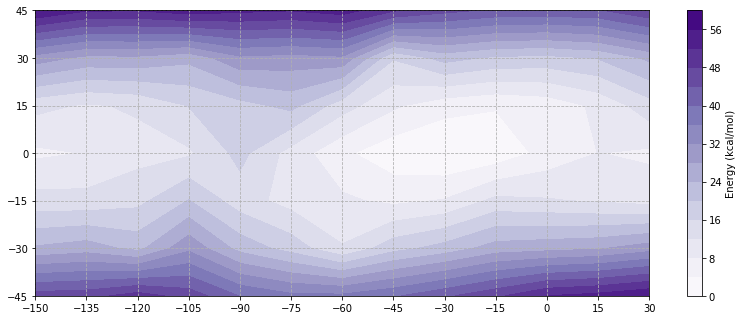

In [4]:
grid_data = energy_plot_from_xyz("scan.xyz")
scanpdb = "scan.pdb"

Execute this cell to view the optimized conformations. Select the grid point by dragging x and y sliders.

In [5]:
interactive_plot = interactive(show_mol_from_pdb, filename=fixed(scanpdb), x=widgets.FloatSlider(min=xmin,max=xmin+xstep*(xpts-1),step=xstep,value=xmin), y=widgets.FloatSlider(min=ymin,max=ymin+ystep*(ypts-1),step=ystep,value=ymin))
output = interactive_plot.children[-1]
output.layout.height = '1000px'
interactive_plot

interactive(children=(FloatSlider(value=-150.0, description='x', max=30.0, min=-150.0, step=15.0), FloatSlider…